In [0]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -q unidecode

     |████████████████████████████████| 245kB 3.3MB/s 


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import numpy as np
np.random.seed(42)
import pandas as pd
import string
import re
import gensim
from nltk.corpus import stopwords
from unidecode import unidecode
from collections import Counter
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv1D, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, LSTM,Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras.layers import Lambda
from keras import backend as K

import gc
import time
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['OMP_NUM_THREADS'] = '4'
eng_stopwords = set(stopwords.words("english"))


Using TensorFlow backend.


In [0]:
print(tf.__version__)

2.2.0-rc3


In [0]:
# load pre-processed data
train = pd.read_csv("train_train_final_processed.csv")
val = pd.read_csv("train_val_final_processed.csv")
test = pd.read_csv("test_final_processed.csv")

In [0]:
# remove non-ascii
special_character_removal = re.compile(r'[^A-Za-z\.\-\?\!\,\#\@\% ]',re.IGNORECASE)
def clean_text(x):
    x_ascii = unidecode(x)
    x_clean = special_character_removal.sub('',x_ascii)
    return x_clean

train['clean_text'] = train['comment_text'].apply(lambda x: clean_text(str(x)))
val['clean_text'] = val['comment_text'].apply(lambda x: clean_text(str(x)))
test['clean_text'] = test['comment_text'].apply(lambda x: clean_text(str(x)))

X_train = train['clean_text'].fillna("something").values
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_val = val['clean_text'].fillna("something").values
y_val = val[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
X_test = test['clean_text'].fillna("something").values


In [0]:
def add_features(df):
    
    df['comment_text'] = df['comment_text'].apply(lambda x:str(x))
    df['total_length'] = df['comment_text'].apply(len)
    df['capitals'] = df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.comment_text.str.count('\S+')
    df['num_unique_words'] = df['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']  

    return df

train = add_features(train)
val = add_features(val)
test = add_features(test)

features = train[['caps_vs_length', 'words_vs_unique']].fillna(0)
val_features = val[['caps_vs_length', 'words_vs_unique']].fillna(0)
test_features = test[['caps_vs_length', 'words_vs_unique']].fillna(0)

ss = StandardScaler()
ss.fit(features)
features = ss.transform(features)
val_features = ss.transform(val_features)
test_features = ss.transform(test_features)

In [0]:
# set training parameters
max_features = 157729
maxlen = 100

# max_features = 283759
# maxlen = 900

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_val_sequence = tokenizer.texts_to_sequences(X_val)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

x_train = sequence.pad_sequences(X_train_sequence, maxlen=maxlen)
x_val = sequence.pad_sequences(X_val_sequence, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test_sequence, maxlen=maxlen)
print(len(tokenizer.word_index))


157729


In [0]:
EMBEDDING_FILE_FASTTEXT="./pretrained/crawl-300d-2M.vec"
EMBEDDING_FILE_TWITTER="./pretrained/glove.twitter.27B.200d.txt"
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index_ft = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE_FASTTEXT,encoding='utf-8'))
embeddings_index_tw = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE_TWITTER,encoding='utf-8'))

In [0]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words,501))

something_tw = embeddings_index_tw.get("something")
something_ft = embeddings_index_ft.get("something")

something = np.zeros((501,))
something[:300,] = something_ft
something[300:500,] = something_tw
something[500,] = 0

def all_caps(word):
    return len(word) > 1 and word.isupper()

def embed_word(embedding_matrix,i,word):
    embedding_vector_ft = embeddings_index_ft.get(word)
    if embedding_vector_ft is not None: 
        if all_caps(word):
            last_value = np.array([1])
        else:
            last_value = np.array([0])
        embedding_matrix[i,:300] = embedding_vector_ft
        embedding_matrix[i,500] = last_value
        embedding_vector_tw = embeddings_index_tw.get(word)
        if embedding_vector_tw is not None:
            embedding_matrix[i,300:500] = embedding_vector_tw

            
# Fasttext vector is used by itself if there is no glove vector but not the other way around.
for word, i in word_index.items():
    
    if i >= max_features: continue
        
    if embeddings_index_ft.get(word) is not None:
        embed_word(embedding_matrix,i,word)
    else:
        #if len(word) > 0
        if len(word) > 0:
            embedding_matrix[i] = something

In [0]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.max_score = 0
        self.not_better_count = 0

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=1)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            if (score > self.max_score):
                print("*** New High Score (previous: %.6f) \n" % self.max_score)
                model.save_weights("best_weights_fixed.h5")
                self.max_score=score
                self.not_better_count = 0
            else:
                self.not_better_count += 1
                if self.not_better_count > 3:
                    print("Epoch %05d: early stopping, high score = %.6f" % (epoch,self.max_score))
                    self.model.stop_training = True

In [0]:
def get_model(features,clipvalue=1.,num_filters=40,dropout=0.5,embed_size=501):
    features_input = Input(shape=(features.shape[1],))
    inp = Input(shape=(maxlen, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    # Layer 2: SpatialDropout1D(0.5)
    x = SpatialDropout1D(dropout)(x)
    
    # Layer 3: Bidirectional CuDNNLSTM
    x = Bidirectional(LSTM(num_filters, return_sequences=True))(x)

    # Layer 4: Bidirectional CuDNNGRU
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    # Layer 5: A concatenation of the last state, maximum pool, average pool and 
    # two features: "Unique words rate" and "Rate of all-caps words"
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, max_pool,features_input])
    
    # Layer 6: output dense layer.
    outp = Dense(6, activation="sigmoid")(x)

    model = Model(inputs=[inp,features_input], outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    return model

In [0]:
model = get_model(features)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 501)     79022229    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 501)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 80)      173440      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

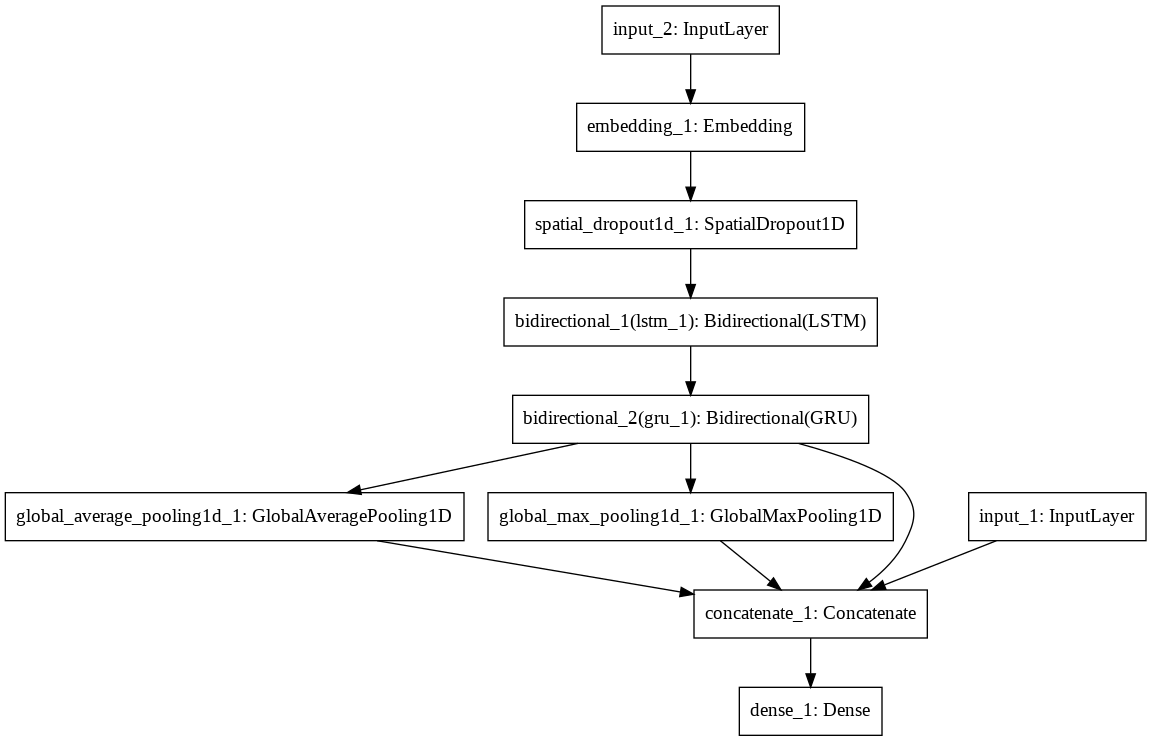

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='rnn_model.png')

In [0]:
model = get_model(features)

batch_size = 32

# Used epochs=100 with early exiting for best score.
epochs = 5
gc.collect()
K.clear_session()

# Change to 10
#num_folds = 10 #number of folds

model = get_model(features)
predict = np.zeros((test.shape[0],6))

# Uncomment for out-of-fold predictions
#scores = []
#oof_predict = np.zeros((train.shape[0],6))

ra_val = RocAucEvaluation(validation_data=([x_val, val_features], y_val), interval = 1)
    
model.fit([x_train, features], y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          callbacks = [ra_val])
gc.collect()
    
#model.load_weights(bst_model_path)
model.load_weights("best_weights_fixed.h5")
predict = model.predict([x_test,test_features], batch_size=batch_size,verbose=1)

Epoch 1/5
15957/15957 [==============================] - 39s 2ms/step

 ROC-AUC - epoch: 1 - score: 0.985138 

*** New High Score (previous: 0.000000) 

Epoch 2/5
15957/15957 [==============================] - 39s 2ms/step

 ROC-AUC - epoch: 2 - score: 0.987666 

*** New High Score (previous: 0.985138) 

Epoch 3/5
15957/15957 [==============================] - 38s 2ms/step

 ROC-AUC - epoch: 3 - score: 0.987819 

*** New High Score (previous: 0.987666) 

Epoch 4/5
15957/15957 [==============================] - 38s 2ms/step

 ROC-AUC - epoch: 4 - score: 0.988361 

*** New High Score (previous: 0.987819) 

Epoch 5/5
15957/15957 [==============================] - 37s 2ms/step

 ROC-AUC - epoch: 5 - score: 0.988387 

*** New High Score (previous: 0.988361) 

153164/153164 [==============================] - 355s 2ms/step


'\nkf = KFold(n_splits=num_folds, shuffle=True, random_state=239)\n\nfor train_index, test_index in kf.split(x_train):\n    \n    kfold_y_train,kfold_y_test = y_train[train_index], y_train[test_index]\n    kfold_X_train = x_train[train_index]\n    kfold_X_features = features[train_index]\n    kfold_X_valid = x_train[test_index]\n    kfold_X_valid_features = features[test_index] \n    \n    gc.collect()\n    K.clear_session()\n    \n    model = get_model(features)\n    \n    ra_val = RocAucEvaluation(validation_data=([kfold_X_valid,kfold_X_valid_features], kfold_y_test), interval = 1)\n    \n    model.fit([kfold_X_train,kfold_X_features], kfold_y_train, batch_size=batch_size, epochs=epochs, verbose=1,\n             callbacks = [ra_val])\n    gc.collect()\n    \n    #model.load_weights(bst_model_path)\n    model.load_weights("best_weights.h5")\n    \n    # disable cross validation, only run one of the ten folders\n    # predict += model.predict([x_test,test_features], batch_size=batch_si

In [0]:
# Prepare for submission
sample_submission = pd.read_csv("sample_submission.csv")
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
sample_submission[class_names] = predict
sample_submission.to_csv('model_RNN_submission.csv',index=False)
